In [153]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
# NumPy is only used to load the .npz partially processed data file. It is later converted to pandas datasets
from numpy import load
import numpy

# Load the dataset from its location in the Google Drive
data = load('/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

edges
[[    0 18427]
 [18427     0]
 [    1 21708]
 ...
 [ 5563  5563]
 [22425 22425]
 [22425 22425]]
features
[[-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.36413375
  -0.12863389]
 [-0.26257643 -0.26505256 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 ...
 [-0.26257643 -0.27648264 -0.26235026 ... -0.18038896 -0.37209702
  -0.22261272]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.21814811]
 [-0.23227507 -0.27648264 -0.26235026 ... -0.19585785 -0.3759032
  -0.2212746 ]]
target
[0 2 1 ... 2 1 0]


In [155]:
# Load the necessary libraries. TensorFlow is the primary library used

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

Initialise the data

In [156]:
# Load the edges as a pandas dataframe
edges = data["edges"]
edges = pd.DataFrame(data=edges, columns=["source", "target"])

print("Edges shape:", edges.shape)

Edges shape: (342004, 2)


In [157]:
# Generate a sample of the edges data
edges.sample(frac=1).head()

,source,target
311466,15785,17370
309010,15531,20433
75651,4731,2586
277341,16960,12704
2147,2725,14854


In [158]:
# Load the pages as a pandas dataframe
id = numpy.arange(22470)
id = pd.DataFrame(data=id)

categories = data["target"]
categories = pd.DataFrame(data=categories)

pages = data["features"]
pages = pd.DataFrame(data=pages)

pages = numpy.concatenate((id, pages, categories), axis=1)

row_names = ["id"] + [f"term_{idx}" for idx in range(128)] + ["category"]
pages = pd.DataFrame(data=pages, columns=row_names)

N = pages.shape[0] #the number of nodes
F = pages.shape[1] #the number of features

print("Pages shape:", pages.shape)
print('Number of nodes (N): ', N)
print('Number of features (F) of each node: ', F)

Pages shape: (22470, 130)
Number of nodes (N):  22470
Number of features (F) of each node:  130


In [159]:
# Generate a sample of the pages data
print(pages.sample(5).T)

                 17051         19087         19250         17484         13216
id        17051.000000  19087.000000  19250.000000  17484.000000  13216.000000
term_0       -0.262576     -0.262576     -0.262576     -0.262576     -0.262576
term_1       -0.276483     -0.276483      2.834831     -0.276483     -0.275669
term_2       -0.262350      1.944968     -0.262350     -0.262350     -0.250628
term_3       -0.299327     -0.289419      3.379642      3.356426     -0.299327
...                ...           ...           ...           ...           ...
term_124     -0.255755     -0.255755      4.341376     -0.255755     -0.255755
term_125     -0.201630     -0.196662     -0.067745      4.997011     -0.199189
term_126      2.673884     -0.374946     -0.375903     -0.375903     -0.372358
term_127     -0.223836     -0.014455     -0.203794     -0.200309     -0.200849
category      2.000000      1.000000      1.000000      1.000000      2.000000

[130 rows x 5 columns]


In [160]:
# Display a count of the number of pages in each category, 
# where the category is represented by a number from 0 to 3.
print(pages.category.value_counts())

2.0    6880
1.0    6495
3.0    5768
0.0    3327
Name: category, dtype: int64


In [161]:
# Convert the page id and edge into zero-based indices 
class_values = sorted(pages["category"].unique())

class_idx = {name: idx for idx, name in enumerate(class_values)}
pages["category"] = pages["category"].apply(lambda value: class_idx[value])

page_idx = {name: idy for idy, name in enumerate(sorted(pages["id"].unique()))}
pages["id"] = pages["id"].apply(lambda name: page_idx[name])
edges["source"] = edges["source"].apply(lambda name: page_idx[name])
edges["target"] = edges["target"].apply(lambda name: page_idx[name])

Visualise the graph

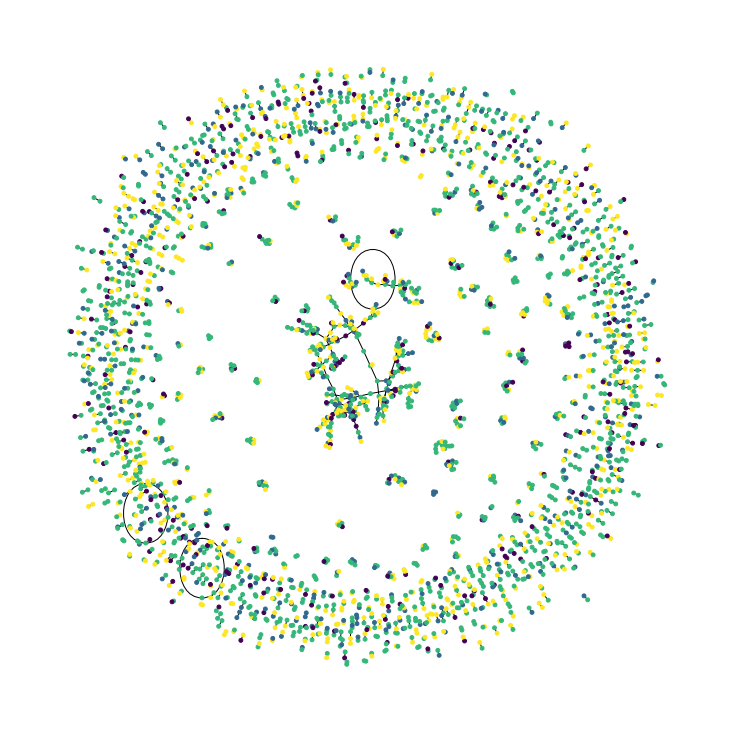

In [162]:
# Plot the graph using a small sample of all the data
plt.figure(figsize=(10, 10))

colours = pages["category"].tolist()

fb_graph = nx.from_pandas_edgelist(edges.sample(n=2000))
page_type = list(pages[pages["id"].isin(list(fb_graph.nodes))]["category"])
nx.draw_spring(fb_graph, node_size=15, node_color=page_type)

In [163]:
# We split the data into train, validation, and test data sets, using a 20:20:60
# train:validation:test split for semi supervised
train_data, val_data, test_data = [], [], []

for _, grouped_data in pages.groupby("category"):
    dataset_length = len(grouped_data.index)
    train_data.append(grouped_data[:dataset_length//10*2])
    val_data.append(grouped_data[dataset_length//10*2:dataset_length//10*4])
    test_data.append(grouped_data[dataset_length//10*4:])

train_data = pd.concat(train_data).sample(frac=1)
val_data = pd.concat(val_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4490, 130)
Validation data shape: (4490, 130)
Test data shape: (13490, 130)


In [164]:
# Prepare the data for training the model
feature_names = set(pages.columns) - {"id", "category"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Convert test, validate, and train pandas datasets features to tensors.
x_train = tf.convert_to_tensor(train_data[feature_names])
x_validate = tf.convert_to_tensor(val_data[feature_names])
x_test = tf.convert_to_tensor(test_data[feature_names])

# Obtain test, validate, and train targets.
y_train = train_data["category"]
y_validate = val_data["category"]
y_test = test_data["category"]

In [165]:
#Create Boolean masks for the train, validate and test datasets
train_mask = numpy.zeros((N,),dtype=bool)
ls_train = [int(x) for x in train_data["id"].tolist()]
train_mask[ls_train] = True

val_mask = numpy.zeros((N,),dtype=bool)
ls_val = [int(x) for x in val_data["id"].tolist()]
val_mask[ls_val] = True

test_mask = numpy.zeros((N,),dtype=bool)
ls_test = [int(x) for x in test_data["id"].tolist()]
test_mask[ls_test] = True

In [166]:
# Encode the labels into one-hot encoding
labels_encoded = []
for value in pages.category:
  letter = [0 for _ in range(len(set(pages.category)))]
  letter[value] = 1
  labels_encoded.append(letter)

In [167]:
# Parameters
channels = 16                 # Number of training channels
stopping_patience = 50        # Patience for early stopping
learning_rate = 0.001         # Learning rate
dropout_rate = 0.5            # Dropout rate for the features
l2_reg = 5*10**(-4)           # Regularisation rate f or l2
num_epochs = 300              # Number of training epochs

In [168]:
!pip install spektral

In [169]:
from spektral.layers import GATConv

# Define the model and create the different layers to be used
X_in = layers.Input(shape=(F, ))
fltr_in = layers.Input((N, ), sparse=True)

dropout_1 = layers.Dropout(dropout_rate)(X_in)
graph_conv_1 = GATConv(channels,
                         activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = layers.Dropout(dropout_rate)(graph_conv_1)
graph_conv_2 = GATConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build the model
model = tf.keras.Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['accuracy']),

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 130)]        0                                            
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 130)          0           input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gat_conv_14 (GATConv)           (None, 16)           2112        dropout_14[0][0]                 
                                                                 input_16[0][0]            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [170]:
# Obtain just the features section of the dataset to use for training
X = data["features"]
X = pd.DataFrame(data=pages)
X = numpy.array(X)

# Build the graph
graph = nx.Graph()
pages = pages["id"]
pages = numpy.array(pages)
edges = data["edges"]
edges = numpy.array(edges)
graph.add_nodes_from(pages)
graph.add_edges_from(edges)

print('Graph info: ', nx.info(graph))

# Create the adjacency matrix A from the graph 
A = nx.adjacency_matrix(graph)
A = GATConv.preprocess(A).astype('f4')

# Create an early stopping function
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=stopping_patience, restore_best_weights=True
    )

train_mask = numpy.array(train_mask)
val_mask = numpy.array(val_mask)
test_mask = numpy.array(test_mask)
labels_encoded = numpy.array(labels_encoded)

# Define the validation data
validation_data = ([X, A], labels_encoded, val_mask)

Graph info:  Graph with 22470 nodes and 171002 edges


In [171]:
# Train the model
history = model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=num_epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[early_stopping]
          )

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_11/gat_conv_15/Reshape_5:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_11/gat_conv_15/Reshape_4:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_11/gat_conv_15/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_11/gat_conv_15/Reshape_8:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_11/gat_conv_15/Reshape_7:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_11/gat_conv_15/Cast_2:0", shape=(2,), dtype=i

1/1 [==============================] - 6s 6s/step - loss: 0.6530 - accuracy: 0.2964 - val_loss: 2.5990 - val_accuracy: 0.2566
Epoch 2/300
1/1 [==============================] - 1s 692ms/step - loss: 0.5974 - accuracy: 0.3067 - val_loss: 2.5799 - val_accuracy: 0.2566
Epoch 3/300
1/1 [==============================] - 1s 662ms/step - loss: 0.4818 - accuracy: 0.3296 - val_loss: 2.5671 - val_accuracy: 0.2566
Epoch 4/300
1/1 [==============================] - 1s 670ms/step - loss: 0.5994 - accuracy: 0.3655 - val_loss: 2.5755 - val_accuracy: 0.2566
Epoch 5/300
1/1 [==============================] - 1s 702ms/step - loss: 0.6321 - accuracy: 0.3488 - val_loss: 2.5775 - val_accuracy: 0.2566
Epoch 6/300
1/1 [==============================] - 1s 666ms/step - loss: 0.5930 - accuracy: 0.3929 - val_loss: 2.5865 - val_accuracy: 0.2566
Epoch 7/300
1/1 [==============================] - 1s 704ms/step - loss: 0.4074 - accuracy: 0.3927 - val_loss: 2.5964 - val_accuracy: 0.2566
Epoch 8/300
1/1 [===========

In [173]:
# Evaluate the accuracy of the model
y_pred = model.predict([X, A], batch_size=N)

report = classification_report(test_mask, numpy.argmax(y_pred,axis=1))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.00      0.00      8980
           1       0.46      0.00      0.00     13490
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.00     22470
   macro avg       0.23      0.00      0.00     22470
weighted avg       0.46      0.00      0.00     22470



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [174]:
# Create a tSNE embeddings plot 
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

tsne_fb = TSNE(n_components=2).fit_transform(activations[3])

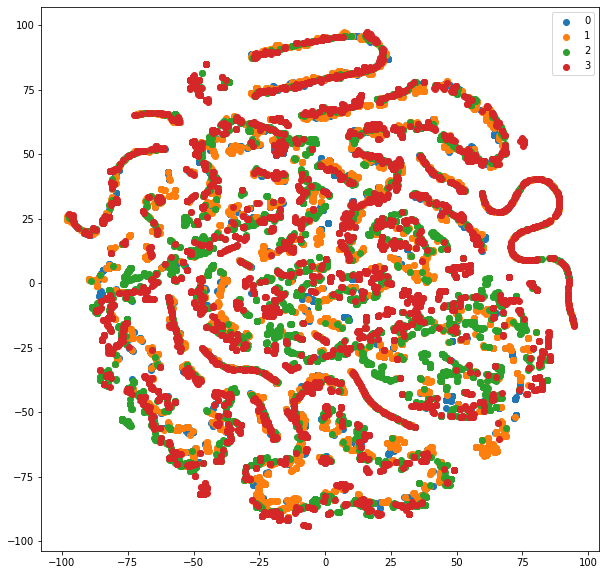

In [175]:
# Creates a function to plot the t-SNE embedding
def plot_tSNE(labels,x_tsne):
    colour_map = numpy.argmax(labels, axis=1)
    plt.figure(figsize=(10,10))
    
    for cl in range(num_classes):
        indices = numpy.where(colour_map==cl)
        indices = indices[0]
        plt.scatter(tsne_fb[indices,0], tsne_fb[indices, 1], label=cl)

    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,tsne_fb)

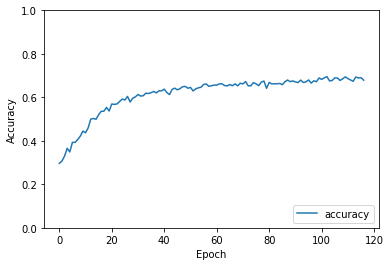

In [183]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

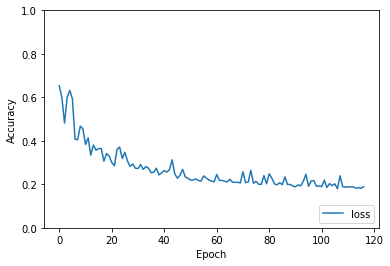

In [184]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')